# Statistical inference of stock returns with linear regression

## Imports & Settings

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
%matplotlib inline

import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Data

In [19]:
DATA_STORE = "../data/linear.h5"
with pd.HDFStore(DATA_STORE) as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [20]:
data = data[data.dollar_vol_rank<100]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('ATVI', Timestamp('2015-08-28 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol_raw         109675 non-null  float64
 2   dollar_vol             109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d   

### Create Model Data

In [22]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Explore Data

In [23]:
s = y.corr().stack()

In [24]:
s.reset_index()

,level_0,level_1,0
0,target_1d,target_1d,1.000000
1,target_1d,target_5d,0.438389
2,target_1d,target_10d,0.310498
3,target_1d,target_21d,0.218600
4,target_5d,target_1d,0.438389
5,target_5d,target_5d,1.000000
6,target_5d,target_10d,0.696938
7,target_5d,target_21d,0.481701
8,target_10d,target_1d,0.310498
9,target_10d,target_5d,0.696938


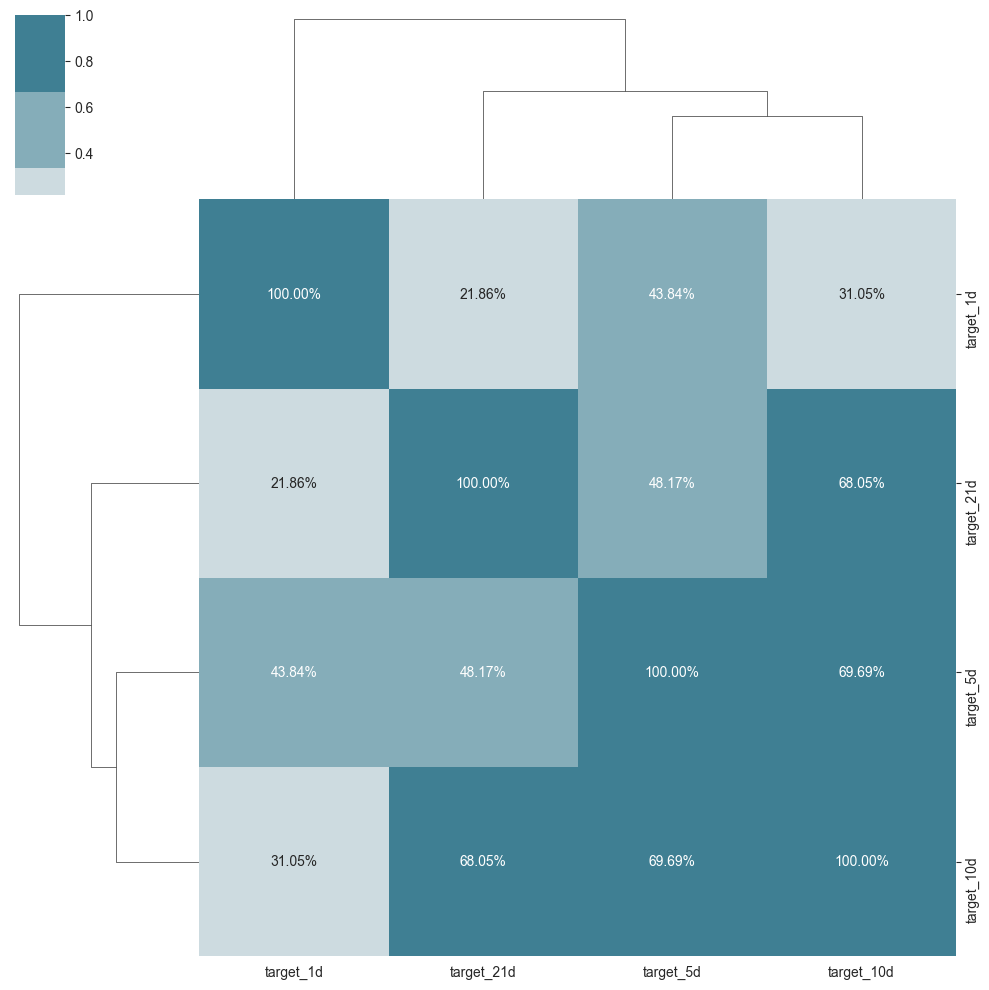

In [25]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

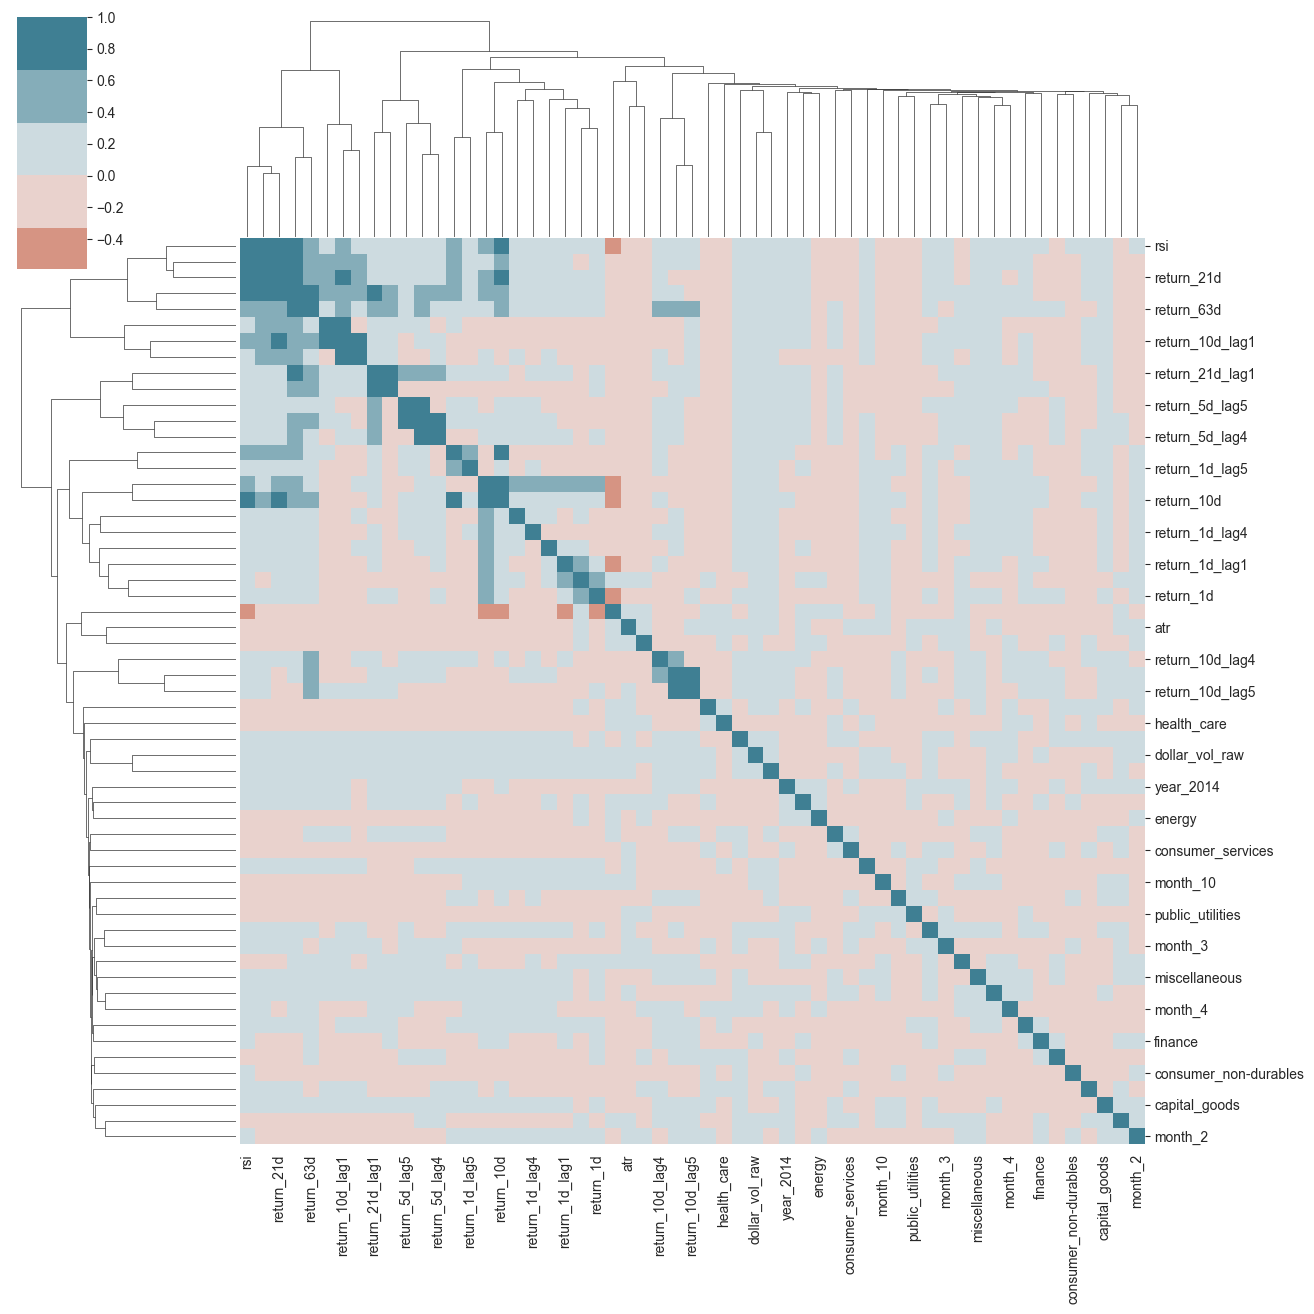

In [26]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [27]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [28]:
#corr_mat.head().append(corr_mat.tail())
pd.concat([corr_mat.head(), corr_mat.tail()])

,var1,var2,corr
581,return_42d,return_63d,0.835634
637,return_63d,return_42d,0.835634
286,macd,rsi,0.817113
62,rsi,macd,0.817113
294,macd,return_21d,0.793892
115,bb_high,rsi,-0.469520
120,bb_high,return_1d,-0.489924
344,return_1d,bb_high,-0.489924
401,return_5d,bb_high,-0.588208
121,bb_high,return_5d,-0.588208


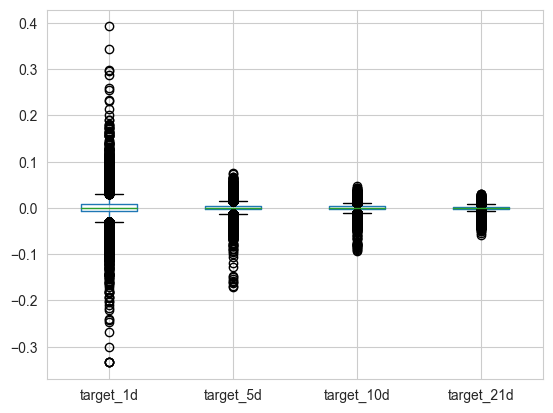

In [29]:
y.boxplot();

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [30]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

### 1-Day Returns

In [32]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     18.84
Date:                Sat, 07 Oct 2023   Prob (F-statistic):          1.46e-186
Time:                        20:31:48   Log-Likelihood:             2.8851e+05
No. Observations:              109675   AIC:                        -5.769e+05
Df Residuals:                  109617   BIC:                        -5.764e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### 5-Day Returns

In [34]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     61.85
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:35:20   Log-Likelihood:             3.7883e+05
No. Observations:              109675   AIC:                        -7.575e+05
Df Residuals:                  109617   BIC:                        -7.570e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

#### Obtain the residuals

In [35]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

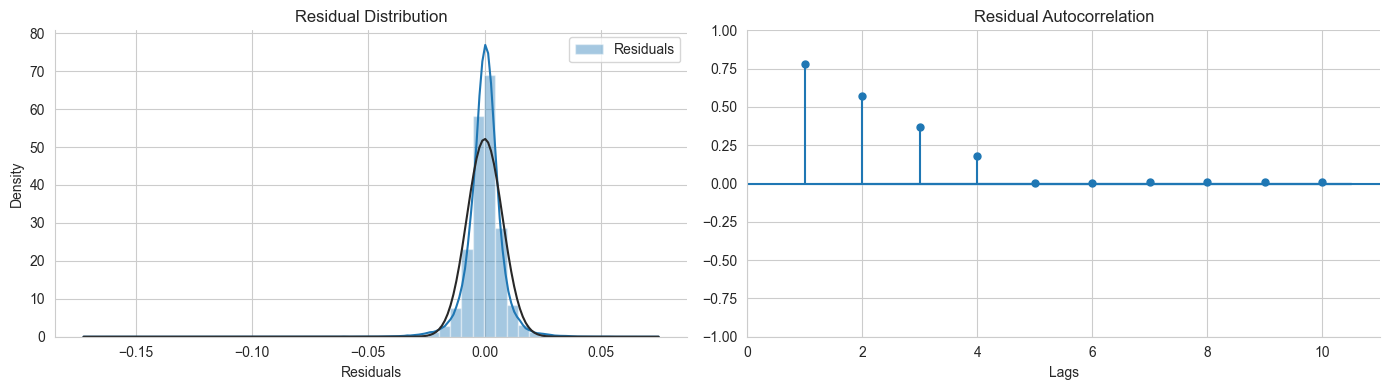

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

### 10-Day Returns

In [38]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     88.76
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:36:57   Log-Likelihood:             4.1901e+05
No. Observations:              109675   AIC:                        -8.379e+05
Df Residuals:                  109617   BIC:                        -8.374e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Monthly Returns

In [39]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     121.6
Date:                Sat, 07 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:38:44   Log-Likelihood:             4.6160e+05
No. Observations:              109675   AIC:                        -9.231e+05
Df Residuals:                  109617   BIC:                        -9.225e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00